In [6]:
# Import helper functions
%run helper.py


def print_histogram(data, label=[]):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(16,7))
    plt.hist(data, bins=81)
    #plt.xticks( np.arange(n_classes) )
    #plt.xticks(np.arange(n_classes), np.bincount(y_train))
    plt.xlabel('Steering angle')
    plt.ylabel('Number of samples')
    if label != []:
        plt.legend([label], fontsize='xx-large')
    plt.show()
    return

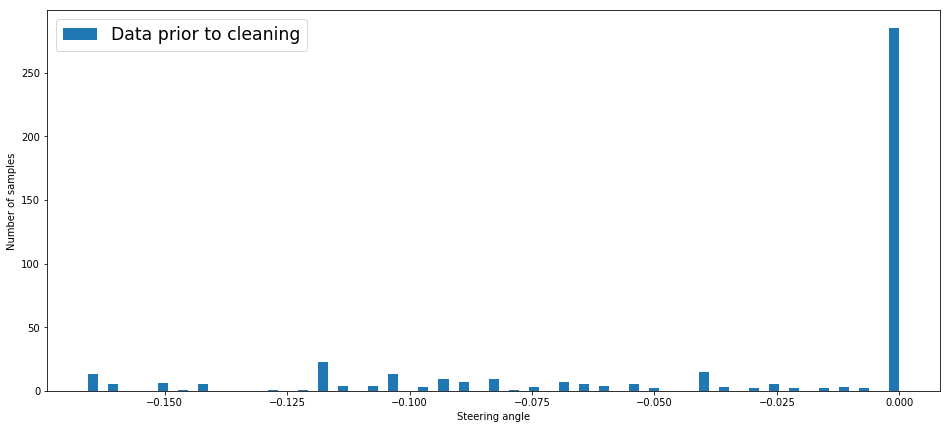

Number of samples in input data: 450
Samples going straight: 284 , Samples steering:  166
Number of random samples going straight that are rescued ( 10.0 % ): 28
Number after dropping large steering angles ( larger than +- 2.0 ): 166
Number of cleaned samples with rescued samples:  194


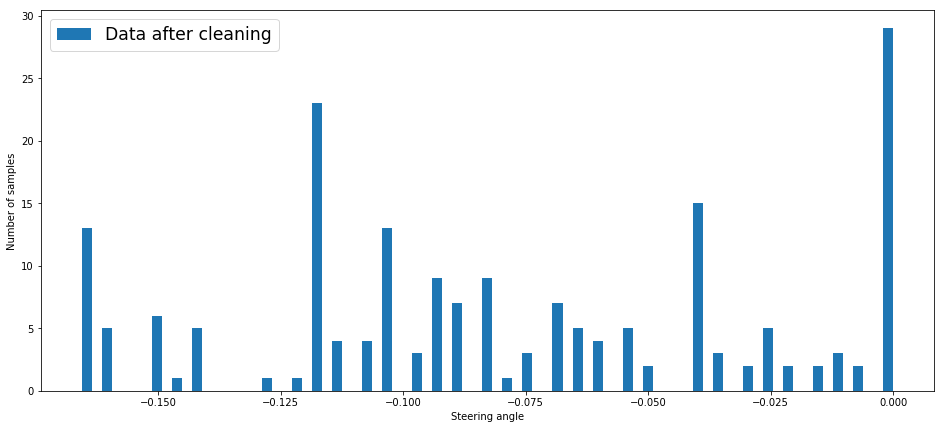

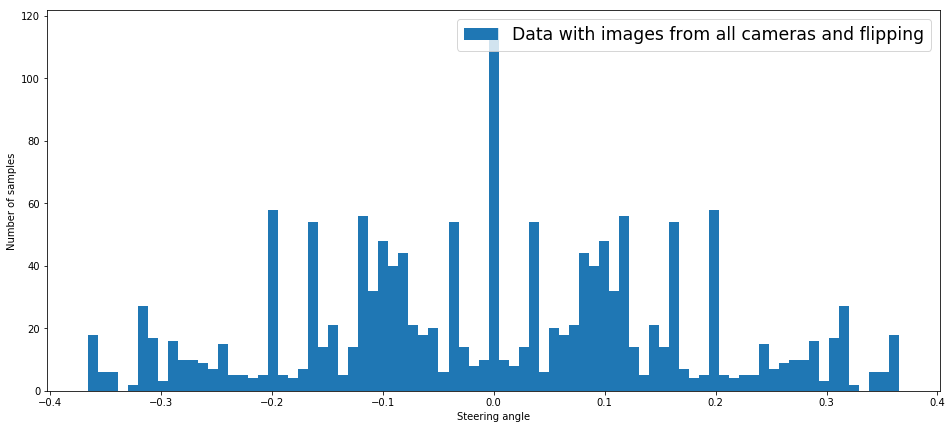

In [7]:
paths = ['../Driving_Data_small/']
driving_log = read_csv(paths)
a = driving_log['Steering Angle'].values
print_histogram(driving_log['Steering Angle'].values, 'Data prior to cleaning')
driving_log = clean_data(driving_log, upper_angle=2.0, zero_frac=0.1)
print_histogram(driving_log['Steering Angle'].values, 'Data after cleaning')

a=[]
a = driving_log['Steering Angle'].values
a = np.append(a,-a)
a = np.append(a, a+0.2)
a = np.append(a, a-0.2)
print_histogram(a, 'Data with images from all cameras and flipping')


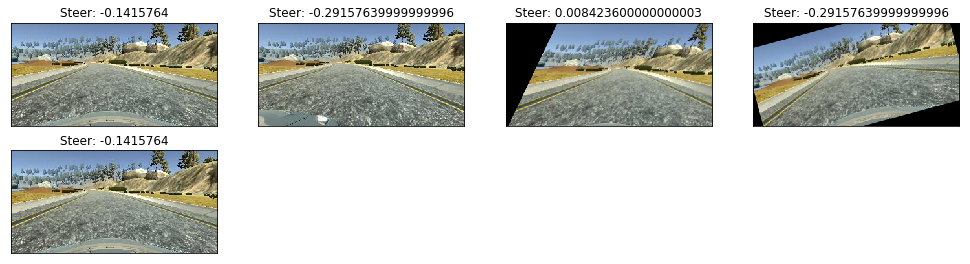

In [22]:
# demonstrator of how generator works
%run helper.py
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array

paths = ['../Driving_Data_small/']
driving_log = read_csv(paths)
index = 80

plt.figure(figsize=(17,9))

image, steering_angle = load_image(driving_log.loc[index])

plt.subplot(4,4,1)
plt.xticks([]), plt.yticks([])
plt.imshow(image, cmap="gray")
plt.title('Steer: ' + str(steering_angle))

image, steering_angle = load_image(driving_log.loc[index],1)
plt.subplot(4,4,2)
plt.xticks([]), plt.yticks([])
plt.imshow(image, cmap="gray")
plt.title('Steer: ' + str(steering_angle))

image, steering_angle = load_image(driving_log.loc[index])
image, steering_angle = shear_image(image, steering_angle, 0)
plt.subplot(4,4,3)
plt.xticks([]), plt.yticks([])
plt.imshow(image, cmap="gray")
plt.title('Steer: ' + str(steering_angle))

image, steering_angle = load_image(driving_log.loc[index])
image, steering_angle = rotate_image(image, steering_angle, 1)
plt.subplot(4,4,4)
plt.xticks([]), plt.yticks([])
plt.imshow(image, cmap="gray")
plt.title('Steer: ' + str(steering_angle))

image, steering_angle = load_image(driving_log.loc[index])
plt.subplot(4,4,5)
plt.xticks([]), plt.yticks([])
plt.imshow(image, cmap="gray")
plt.title('Steer: ' + str(steering_angle))



plt.show()

#print(driving_log.loc[27])


load 0.561446 (160, 320, 3) <class 'numpy.ndarray'>
flip 0.561446 (160, 320, 3) <class 'numpy.ndarray'>
brightness 0.67201 (160, 320, 3) <class 'numpy.ndarray'>
h_shift 0.642841 (160, 320, 3) <class 'numpy.ndarray'>
v_shift 0.616013 (160, 320, 3) <class 'numpy.ndarray'>
rotate 0.548745 (160, 320, 3) <class 'numpy.ndarray'>
shear 0.554194 (160, 320, 3) <class 'numpy.ndarray'>


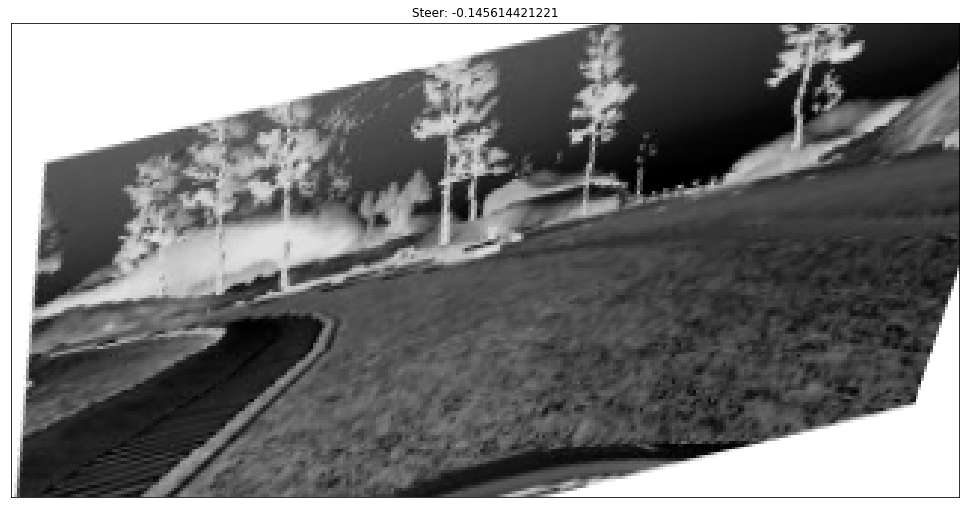

In [188]:
%run helper.py
paths = ['../SDCND_small/']
driving_log = read_csv(paths)
index = 85

plt.figure(figsize=(17,9))

sample = driving_log.loc[index]
rand = np.random.random(9)

# 1. Camera: left image | center image | right image
image, steering_angle = load_image(sample, rand[0])
print('load', img_to_array(image).mean(), img_to_array(image).shape, type(image))

# 2. Flip: normal | flipped
image, steering_angle = flip_image(image, steering_angle, rand[1])
print('flip', img_to_array(image).mean(), img_to_array(image).shape, type(image))

# 3. Brightness: bright | normal | dark
image = brightness_image(image, rand[2])
print('brightness', img_to_array(image).mean(), img_to_array(image).shape, type(image))

# 4. Horizontal shift: left | normal | right
image = h_shift_image(image, rand[3])
print('h_shift', img_to_array(image).mean(), img_to_array(image).shape, type(image))

# 5. Vertical shift: up | normal | down
image = v_shift_image(image, rand[4])
print('v_shift', img_to_array(image).mean(), img_to_array(image).shape, type(image))

#image = img_to_array(image)/255

image, steering_angle = rotate_image(image, steering_angle, rand[5])
print('rotate', img_to_array(image).mean(), img_to_array(image).shape, type(image))

image, steering_angle = shear_image(image, steering_angle, rand[6])
print('shear', img_to_array(image).mean(), img_to_array(image).shape, type(image))

image = invert_image(image, rand[7])

image = grayscale(image, rand[8])


plt.xticks([]), plt.yticks([])
plt.imshow(image, cmap="gray")
plt.title('Steer: ' + str(steering_angle))
    
plt.show()

#print(driving_log.loc[27])

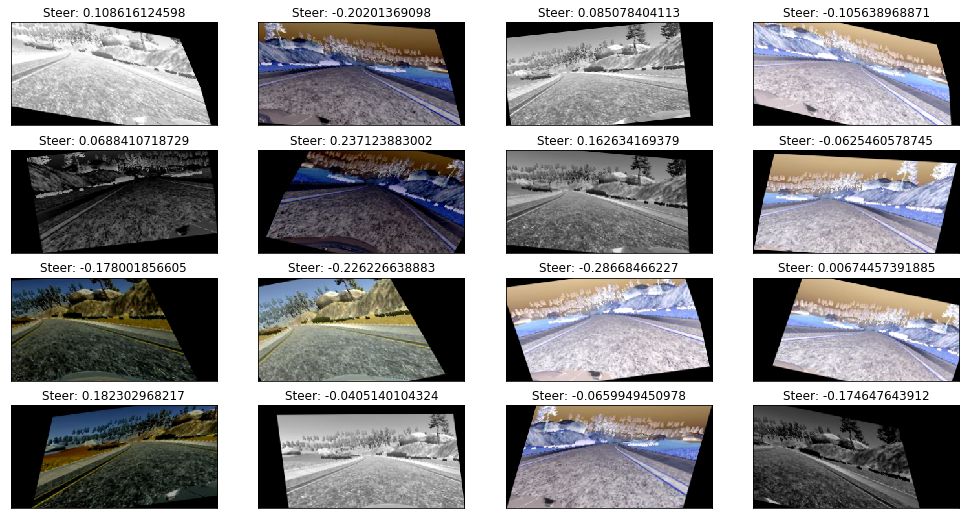

In [21]:

driving_log = read_csv(paths)
index = 85

plt.figure(figsize=(17,9))

for n in range(16):
    image, steering_angle = load_and_augment_image(driving_log.loc[index])

    
    plt.subplot(4,4,n+1)
    
    plt.xticks([]), plt.yticks([])
    plt.imshow(image, cmap="gray")
    plt.title('Steer: ' + str(steering_angle))
    
plt.show()

#print(driving_log.loc[27])